<a href="https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GREMLIN_TF v1.0
GREMLIN implemented in tensorflow

In [0]:
# ------------------------------------------------------------
# "THE BEERWARE LICENSE" (Revision 42):
# <so@g.harvard.edu> and <pkk382@g.harvard.edu> wrote this code.
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy us a beer in return.
# --Sergey Ovchinnikov and Peter Koo
# ------------------------------------------------------------
#
# if you use this code, please cite the following papers:
#
# Balakrishnan, Sivaraman, Hetunandan Kamisetty, Jaime G. Carbonell,
# Su‐In Lee, and Christopher James Langmead.
# "Learning generative models for protein fold families."
# Proteins: Structure, Function, and Bioinformatics 79, no. 4 (2011): 1061-1078.
#
# Kamisetty, Hetunandan, Sergey Ovchinnikov, and David Baker.
# "Assessing the utility of coevolution-based residue–residue
# contact predictions in a sequence-and structure-rich era."
# Proceedings of the National Academy of Sciences (2013): 201314045.

## libraries

In [0]:
# IMPORTANT, only tested using PYTHON 3!
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from scipy import stats
import pandas as pd

## Params

In [0]:
################
# note: if you are modifying the alphabet
# make sure last character is "-" (gap)
################
alphabet = "ARNDCQEGHILKMFPSTWYV-"
states = len(alphabet)
a2n = {}
for a,n in zip(alphabet,range(states)):
  a2n[a] = n
################

def aa2num(aa):
  '''convert aa into num'''
  if aa in a2n: return a2n[aa]
  else: return a2n['-']

## Functions for working with MSA

In [0]:
# from fasta
def parse_fasta(filename,limit=-1):
  '''function to parse fasta'''
  header = []
  sequence = []
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      if len(header) == limit:
        break
      header.append(line[1:])
      sequence.append([])
    else:
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  return np.array(header), np.array(sequence)
  
def mk_msa(seqs):
  '''converts list of sequences to numpy array'''
  msa = []
  for seq in seqs:
    msa.append([aa2num(aa) for aa in seq])
  return np.array(msa)

def filt_gaps(msa,gap_cutoff=0.5):
  '''filters alignment to remove gappy positions'''
  tmp = np.zeros_like(msa)
  tmp[np.where(msa == 20)] = 1
  non_gaps = np.where(np.sum(tmp.T,-1).T/msa.shape[0] < gap_cutoff)[0]
  return msa[:,non_gaps],non_gaps

def get_eff(msa,eff_cutoff=0.8):
  '''compute effective weight for each sequence'''
  ncol = msa.shape[1]
  # pairwise identity
  msa_sm = (msa[:,None,:]==msa).sum(2)/ncol

  # weight for each sequence
  msa_w = np.zeros_like(msa_sm)
  msa_w[np.where(msa_sm >= eff_cutoff)] = 1
  msa_w = 1/np.sum(msa_w,-1)
  
  return msa_w

## GREMLIN

In [0]:
def GREMLIN(msa):  
  
  # compute effective weight for each sequence
  msa_eff = get_eff(msa,0.8)

  # compute effective number of sequences
  neff = np.sum(msa_eff)

  # store shape of msa
  nrow = msa.shape[0] # num rows (sequences)
  ncol = msa.shape[1] # num cols (positions)

  ##############################################################
  # SETUP COMPUTE GRAPH
  ##############################################################
  
  # kill any existing tensorflow graph
  tf.reset_default_graph()

  # msa (multiple sequence alignment) 
  MSA = tf.constant(msa, tf.int32, name="msa")
  # one-hot encode msa
  OH_MSA = tf.one_hot(MSA,states)

  # msa weight
  MSA_EFF = tf.constant(msa_eff, tf.float32, name="msa_eff")

  # 1-body-term of the MRF
  V = tf.get_variable(name="V", shape=[ncol,states], 
                      dtype=tf.float32, initializer=tf.zeros_initializer)
  
  ########################################
  # V
  ########################################
  H_V = tf.reduce_sum(tf.multiply(OH_MSA,V),axis=-1)
  Z_V = tf.reduce_logsumexp(V,axis=-1)
  LL_V = tf.reduce_sum(H_V-Z_V,axis=1)

  ########################################
  # V + W
  ########################################

  # 2-body-term of the MRF
  W_tmp = tf.get_variable(name="W_tmp", shape=[states,states,ncol,ncol], 
                          dtype=tf.float32, initializer=tf.zeros_initializer)
  
  # set diagional to zero, symmetrize and transpose to [ncol,states,ncol,states]
  W_tmp = W_tmp - tf.matrix_band_part(W_tmp,0,0)
  W_tmp = W_tmp + tf.transpose(W_tmp,[1,0,3,2])
  W = tf.transpose(W_tmp,[2,0,3,1],name="W")

  VW = V + tf.tensordot(OH_MSA,W,2)

  # hamiltonian
  H = tf.reduce_sum(tf.multiply(OH_MSA,VW),axis=2)
  # local Z (parition function)
  Z = tf.reduce_logsumexp(VW,axis=2)

  # Psuedo-Log-Likelihood
  PLL = tf.reduce_sum(H - Z, axis=1)

  # Regularization
  def L2(x): return tf.reduce_sum(tf.square(x))
  L2_V = 0.01 * L2(V)
  L2_W = 0.01 * L2(W) * 0.5 * tf.constant((ncol-1)*(states-1),tf.float32)

  # loss function(s) to minimize
  loss_V = -tf.reduce_sum(LL_V * MSA_EFF) + L2_V
  loss = -tf.reduce_sum(PLL * MSA_EFF) + L2_V + L2_W
  
  ##############################################################
  # MINIMIZE LOSS FUNCTION
  ##############################################################
  
  with tf.Session() as sess:
    # initialize variables V and W
    sess.run(tf.global_variables_initializer())

    # optimize V
    # we find optimizing V first, requires less steps for convergence!
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss_V,method="L-BFGS-B",
                                                       options={'maxiter': 100},var_list=[V])
    optimizer.minimize(sess)
    
    # optimize V and W
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss,method="L-BFGS-B",
                                                       options={'maxiter': 100})
    optimizer.minimize(sess)

    # save the V and W parameters of the MRF
    V_ = sess.run(V)
    W_ = sess.run(W)
    
  mrf = {"idx": msa_idx,
         "v": V_,
         "w": W_}
  return mrf, neff

## Functions for extracting contacts from MRF

In [0]:
###################
def normalize(x):
  x = stats.boxcox(x - np.amin(x) + 1.0)[0]
  x_mean = np.mean(x)
  x_std = np.std(x)
  return((x-x_mean)/x_std)

def get_mtx(mrf,idx=None):
  '''get mtx given mrf'''
  
  # if no index provide, use indices from input mrf
  if idx is None:
    idx = np.arange(0,mrf["v"].shape[0])
  
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(mrf["w"][:,:-1,:,:-1]),(1,3)))

  # apc (average product correction)
  ap = np.sum(raw,0,keepdims=True)*np.sum(raw,1,keepdims=True)/np.sum(raw)
  apc = raw - ap
  np.fill_diagonal(apc,0)
  
  # Note: the indices of the GREMLN MRF output do NOT match the indices 
  # of the MSA because some of the positions were removed due to gaps
  # the following fixes the indices
  
  cut_idx = np.triu_indices_from(apc,1)
  mtx = {"i": idx[cut_idx[0]],
         "j": idx[cut_idx[1]],
         "raw": raw[cut_idx],
         "apc": apc[cut_idx],
         "zscore": normalize(apc[cut_idx])}
  return mtx

def plot_mtx(mtx):
  '''plot the mtx'''
  max_j = mtx["j"].max()+1
  tmp = np.zeros((max_j,max_j))
  tmp[(mtx["i"],mtx["j"])] = mtx["zscore"]

  plt.figure(figsize=(5,5))
  plt.imshow(tmp+tmp.T, cmap='Blues', interpolation='none', vmin=1, vmax=3)
  plt.grid(False)
  plt.show()

## EXAMPLE

In [7]:
# download example fasta MSA
!wget https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4FAZA.fas

--2018-12-09 18:49:51--  https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4FAZA.fas
Resolving gremlin2.bakerlab.org (gremlin2.bakerlab.org)... 128.95.160.155
Connecting to gremlin2.bakerlab.org (gremlin2.bakerlab.org)|128.95.160.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140310 (137K)
Saving to: ‘4FAZA.fas.3’

4FAZA.fas.3         100%[===================>] 137.02K  --.-KB/s    in 0.1s    

2018-12-09 18:49:51 (1.16 MB/s) - ‘4FAZA.fas.3’ saved [140310/140310]



In [0]:
##############################################################
# PREP MSA
##############################################################
# parse fasta
names, seqs = parse_fasta("4FAZA.fas")

# convert seqs to array
msa = mk_msa(seqs)

# remove positions with more than > 50% gaps
msa, msa_idx = filt_gaps(msa,0.5)

In [9]:
%%time
# run GREMLIN
mrf, neff = GREMLIN(msa)
print(f"neff {neff}")

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 50461.851562
  Number of iterations: 84
  Number of functions evaluations: 106
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 26510.845703
  Number of iterations: 100
  Number of functions evaluations: 103
neff 502.54895584948974
CPU times: user 37.8 s, sys: 10 s, total: 47.9 s
Wall time: 36.3 s


## Explore the contact map

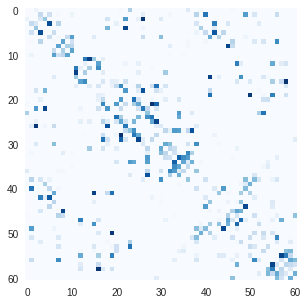

In [10]:
mtx = get_mtx(mrf,msa_idx)  
plot_mtx(mtx)

## Look at top co-evolving residue pairs

In [0]:
# load mtx into pandas dataframe
pd_mtx = pd.DataFrame(mtx,columns=["i","j","zscore"])

In [12]:
# get contacts with sequence seperation > 5
# sort by zscore, show top 10
top = pd_mtx.loc[pd_mtx['j'] - pd_mtx['i'] > 5].sort_values("zscore",ascending=False)
top.head(10)

,i,j,zscore
1056,21,28,2.977183
881,16,58,2.962240
142,2,26,2.941974
999,19,50,2.922539
820,15,41,2.858876
488,8,45,2.822129
251,4,22,2.816465
1278,27,37,2.749992
934,18,26,2.732452
326,5,42,2.693390


## Explore the MRF

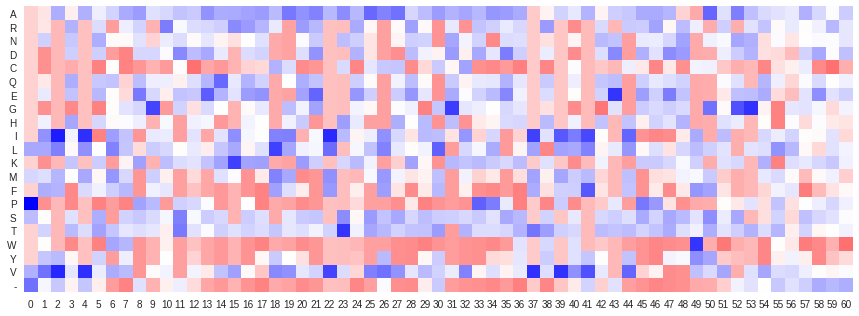

In [13]:
def plot_v(mrf,idx=None):
  
  # if no index provide, use indices from input mrf
  if idx is None:
    idx = np.arange(0,mrf["v"].shape[0])
  
  al_a = list(alphabet)
  v = mrf["v"].T
  mx = np.max((v.max(),np.abs(v.min())))
  plt.figure(figsize=(v.shape[1]/4,states/4))
  plt.imshow(-v,cmap='bwr',vmin=-mx,vmax=mx)
  plt.xticks(np.arange(v.shape[1]))
  plt.yticks(np.arange(0,21))
  plt.grid(False)
  ax = plt.gca()
  ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: idx[x])) 
  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x]))
  
plot_v(mrf,msa_idx)

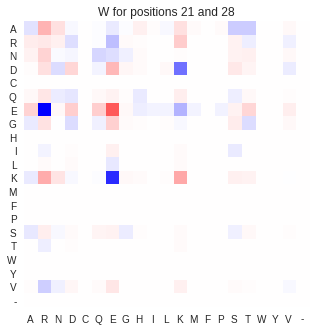

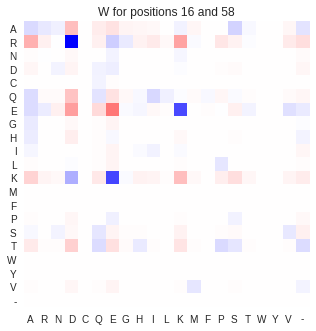

In [14]:
def plot_w(mrf,i,j,idx=None):
  # if no index provide, use indices from input mrf
  if idx is None:
    idx = np.arange(0,mrf["v"].shape[0])
    
  al_a = list(alphabet)
  
  ref = {}
  for n,m in zip(idx,range(idx.shape[0])):
    ref[n] = m
  
  w = mrf["w"][ref[i],:,ref[j],:]
  mx = np.max((w.max(),np.abs(w.min())))
  plt.figure(figsize=(states/4,states/4))
  plt.imshow(-w,cmap='bwr',vmin=-mx,vmax=mx)
  plt.xticks(np.arange(0,states))
  plt.yticks(np.arange(0,states))
  plt.grid(False)
  ax = plt.gca()
  ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x])) 
  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x]))
  plt.title(f"W for positions {i} and {j}")
  plt.show()

for n in range(2):
  i = int(top.iloc[n]["i"])
  j = int(top.iloc[n]["j"])
  plot_w(mrf,i,j,msa_idx)

## validating output
(comparing to known output from GREMLIN_cpp version)

In [15]:
!wget http://files.ipd.uw.edu/krypton/4FAZA.out

--2018-12-09 18:50:33--  http://files.ipd.uw.edu/krypton/4FAZA.out
Resolving files.ipd.uw.edu (files.ipd.uw.edu)... 128.95.160.135, 128.95.160.134
Connecting to files.ipd.uw.edu (files.ipd.uw.edu)|128.95.160.135|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65730 (64K) [application/octet-stream]
Saving to: ‘4FAZA.out.1’

4FAZA.out.1         100%[===================>]  64.19K  --.-KB/s    in 0.1s    

2018-12-09 18:50:33 (557 KB/s) - ‘4FAZA.out.1’ saved [65730/65730]



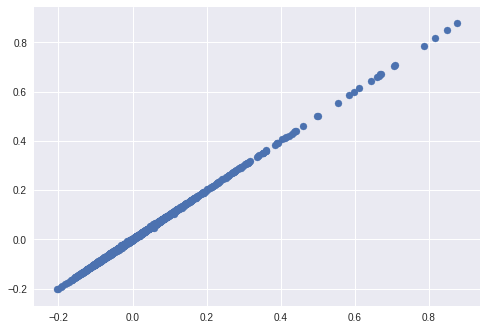

In [17]:
pd_test = pd.read_table("4FAZA.out",sep=" ")
plt.scatter(pd_test["apc"],mtx["apc"])
plt.show()